In [0]:
from IPython.display import  clear_output
# solution for Google Colab rendering from here: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils
clear_output()

In [0]:

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env    

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import torch
import torch.nn as nn
from torch.optim import Adam
import time
from collections import defaultdict
from tqdm import tqdm_notebook
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import  clear_output
from pyvirtualdisplay import Display
%matplotlib inline

display = Display(visible=0, size=(1400, 900))
display.start()

env = gym.make("MountainCar-v0")
env = wrap_env(env)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(2,)
Action space: Discrete(3)


initial observation code: [-0.40210651  0.        ]


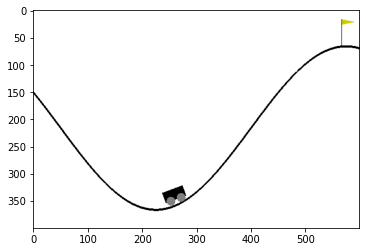

In [4]:
obs0 = env.reset()
print("initial observation code:", obs0)
plt.figure()
plt.imshow(env.render('rgb_array'))
plt.show()
# Note: in MountainCar, observation is just two numbers: car position and velocity

# Intro
In this environment, you get a reward of +100 when the car reaches the goal position at the top. But reward function is sparse since until the car reach the goal it won't get anything. It's unlikely that with randomly initialized policy agent will reach the goal, get reward's feedback and update the policy. So to tackle this problem let's introduce new reward function `custom_reward`.

Some function templates were taken from https://github.com/yandexdataschool/Practical_RL/tree/coursera


# Cross Entropy Method

In [0]:
def custom_reward(state):
    if state[0] >= 0.5:
        return 10
    if state[0] > -0.4:
        return (1+state[0])**2
    return 0

In [0]:
def generate_session(agent, env, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.
    total_real_reward = 0.

    n_actions = env.action_space.n
    s = env.reset()

    for t in range(t_max):

        # unsqueeze batch dimesion
        policy = agent.predict_proba([s])[0]

        a = np.random.choice(np.arange(n_actions),
                             size = 1,
                             p=policy)[0]

        new_s, r, done, info = env.step(a)

        # Record state, action and add up reward to states,actions and total_reward accordingly.
        states.append(s)
        actions.append(a)
        total_reward += custom_reward(s)
        total_real_reward += r

        s = new_s
        
        if done:
            break
    return states, actions, total_reward, total_real_reward

In [0]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):

    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = [states_batch[i] for i,r_i in enumerate(rewards_batch) if r_i > reward_threshold] 
    elite_actions = [actions_batch[i] for i,r_i in enumerate(rewards_batch) if r_i > reward_threshold] 


    elite_states_all = np.concatenate(elite_states)
    elite_actions_all = np.concatenate(elite_actions)

    elite_states_actions = []  
    for s,a in zip(elite_states_all, elite_actions_all):
        elite_states_actions.append([s,a])

    elite_states_actions = np.array(elite_states_actions)
    elite_states, elite_actions = elite_states_actions[:,0], elite_states_actions[:,1]

    return elite_states, elite_actions

mean reward = 3811.943, threshold=4644.091


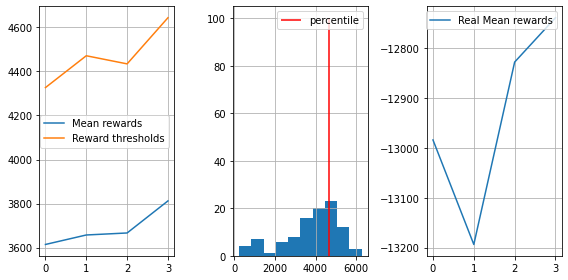

Epoch 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
n_sessions = 100
percentile = 70
n_epochs = 1000
session_ticks = 15000
env = gym.make("MountainCar-v0").env
n_actions = env.action_space.n
agent = MLPClassifier(hidden_layer_sizes=(32, 64, 32),
                      activation='tanh',
                      warm_start=True,  
                      max_iter=1 
                      )
# initialize agent to the dimension of state an amount of actions
agent.fit(np.array([env.reset()]*n_actions), np.arange(n_actions))
t_0 = time.time()
log_dict = defaultdict(list)

for i in range(n_epochs):
    print (f'Epoch {i}')
    # generate new sessions
    sessions = [ generate_session(agent, env, t_max=session_ticks) for session_number in tqdm_notebook(range(n_sessions)) ]

    states_batch, actions_batch, rewards_batch, real_rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions =  select_elites(states_batch, 
                                                 actions_batch, 
                                                 rewards_batch, 
                                                 percentile=percentile)
    
    # make one agent's optimization step 
    agent.fit(np.stack(elite_states), elite_actions.astype(int))

    # logs
    mean_reward = np.mean(rewards_batch)
    mean_real_reward = np.mean(real_rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)

    log_dict['mean_real_reward'].append(mean_real_reward)
    log_dict['mean_reward'].append(mean_reward)
    log_dict['threshold'].append(threshold)

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 3, 1)
    plt.plot(log_dict['mean_reward'], label='Mean rewards')
    plt.plot(log_dict['threshold'], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.hist(rewards_batch)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(log_dict['mean_real_reward'], label='Real Mean rewards')
    plt.legend()
    plt.grid()
    plt.tight_layout()  
    plt.show()
